**KAGGLE STARTING CODE**

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
device = "cuda"

/kaggle/input/topgun4d/top_gun_opendata_4.parquet
/kaggle/input/topgun6/top_gun_opendata_6.parquet
/kaggle/input/topgun1/top_gun_opendata_1.parquet
/kaggle/input/topgun/top_gun_opendata_2.parquet


**Importing libraries**

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split
import seaborn as sns

**Reading the data file**

In [21]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq

chunk_size = 60

def get_dataset(data_dir):
    dfs = []
    for file_name in os.listdir(data_dir):
        parquet_file = pq.ParquetFile(f'{data_dir}/{file_name}')
        total_rows = parquet_file.metadata.num_rows

        for i in range(0, total_rows, chunk_size):
            chunk = parquet_file.read_row_group(i)
            df = chunk.to_pandas()
            dfs.append(df)

    dataset = pd.concat(dfs, ignore_index=True)
    return dataset

def to_3d(arr):
    return np.array([np.stack(np.stack(arr)[i], axis=-1) for i in range(8)])

**Prepartion of DATA**

In [22]:
# Load dataset
DATA_DIR2 = "/kaggle/input/topgun"
DATA_DIR1 = "/kaggle/input/topgun1"
DATA_DIR4 = "/kaggle/input/topgun4d"
DATA_DIR6 = "/kaggle/input/topgun6"
df = get_dataset(DATA_DIR2)
df1 = get_dataset(DATA_DIR1)
df4 = get_dataset(DATA_DIR4)
df6 = get_dataset(DATA_DIR6)

dataset = pd.concat([df, df1,df4, df6], ignore_index=True)

# Check the shape of the combined dataset
print(dataset.shape)

# Display the first few rows
print(dataset.head())


# Apply the transformation efficiently
dataset['X_jet'] = dataset['X_jet'].apply(to_3d)

# Check shape of transformed data
print(dataset['X_jet'][0].shape)  # Should print (8, 125, 125)

(10020, 5)
                                               X_jet           m  iphi  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  286.703217   5.0   
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  123.929375  39.0   
2  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  326.478912  40.0   
3  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  381.457001  66.0   
4  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  389.105591  55.0   

           pt  ieta  
0  905.279175  18.0  
1  855.476379  18.0  
2  434.624542  26.0  
3  765.412109  13.0  
4  837.912048  37.0  
(8, 125, 125)


**Simple plot for a x_jet channel**

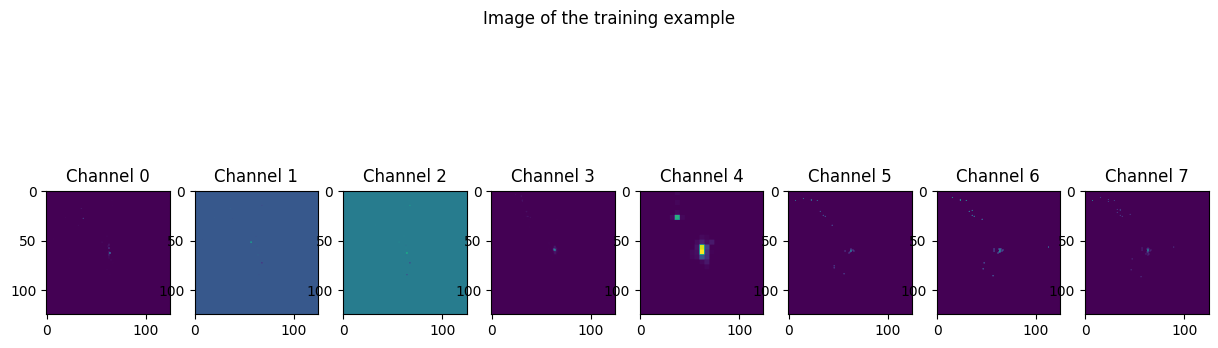

In [23]:
import matplotlib.pyplot as plt

# Plot the first 8 channels of the first training example
fig, axes = plt.subplots(1, 8, figsize=(15, 5))  # 1 row, 8 columns

for i in range(8):  # Assuming X_jets has at least 3 channels
    axes[i].imshow(dataset['X_jet'][9][i, :, :], cmap='viridis')  # Use cmap for better visualization
    axes[i].set_title(f"Channel {i}")

plt.suptitle("Image of the training example")
plt.show()

# Simple plot for x_jet one channel, multiple jets plots

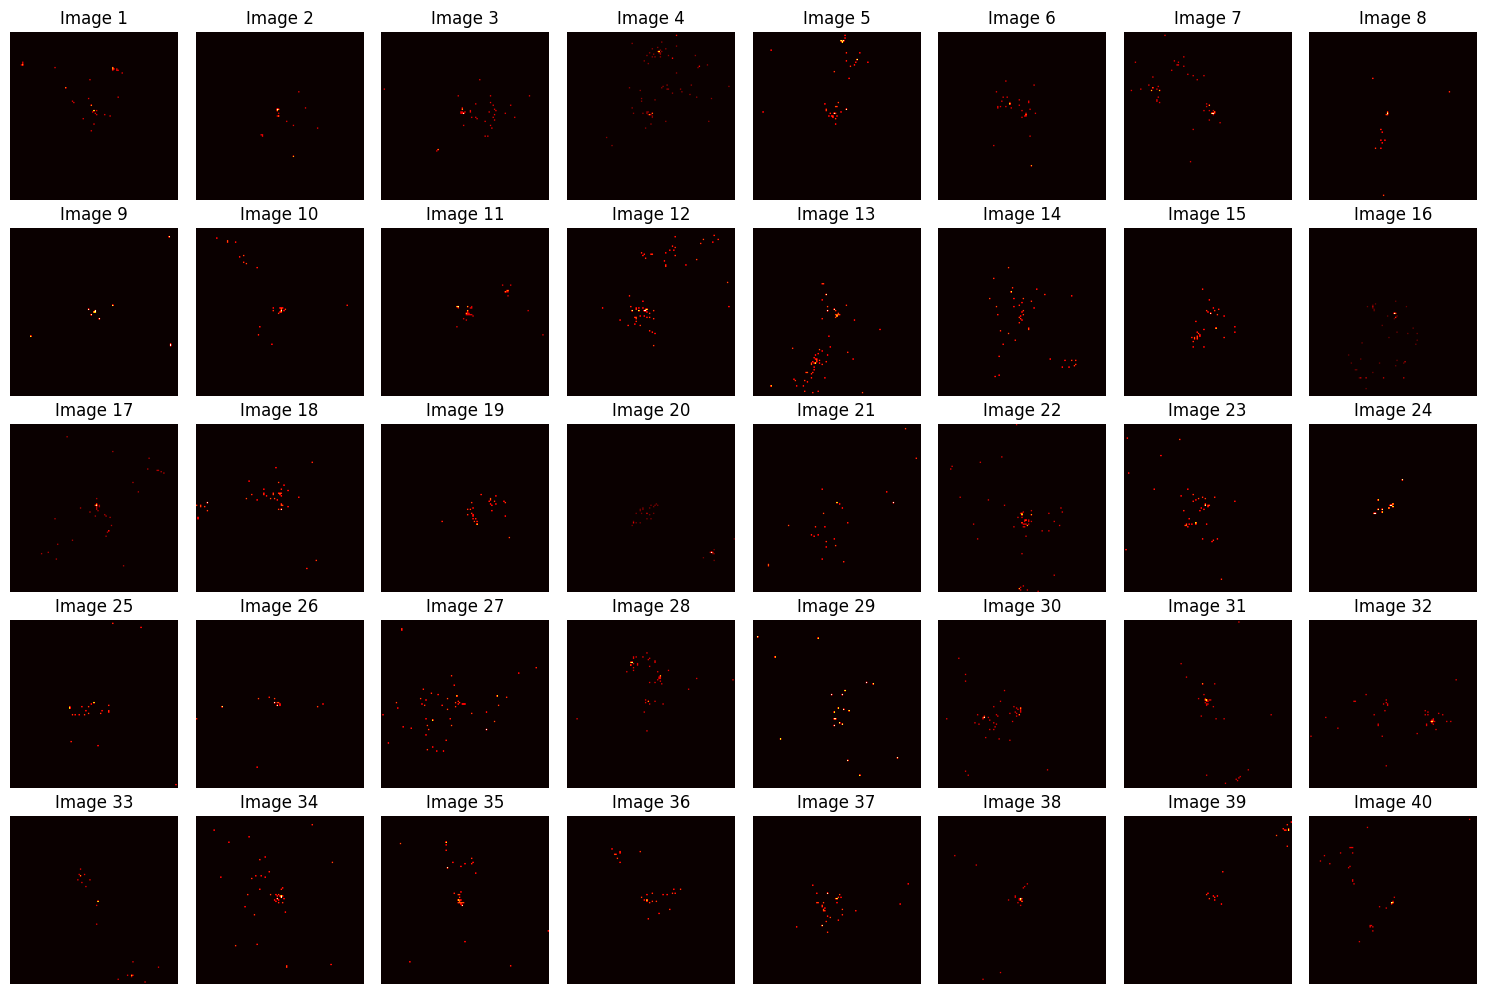

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15, 10))  # 10x8 grid for 80 images

for i, ax in enumerate(axes.flatten()):
    if i >= len(dataset):  # Avoid index error if dataset has fewer than 80 samples
        ax.axis('off')  # Hide extra subplots
        continue

    image = dataset['X_jet'][i][6, :, :]  # Using channel 5 of each sample
    ax.imshow(image, cmap='hot')  # Better visualization
    ax.set_title(f'Image {i+1}')
    ax.axis('off')  # Remove axes for better display

plt.tight_layout()
plt.show()


# A function to plot channels and jets

In [25]:
def image_channel(n, channel):
    total_channels = 8

    # Validate channel number
    if channel < 0 or channel >= total_channels:
        raise ValueError(f"Invalid channel: {channel}. Must be between 0 and {total_channels - 1}.")

    cols = 8
    rows = n
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 8))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(dataset['X_jet']):
            break  # Don't access more images than exist

        # Extract the selected channel from the (8, 125, 125) array
        image = dataset['X_jet'][i][channel, :, :]

        ax.imshow(image, cmap='hot')
        ax.set_title(f"Image {i+1}")
        ax.axis("off")

        if i % cols == 0:  # First column of each row
            row_number = (i // cols) + 1
            ax.text(-0.5, 62, f"Jet {row_number}", va='center', ha='right', fontsize=8, weight='bold', rotation=90)


    plt.tight_layout()
    plt.show()

    return rows * cols
#channel index:0,1,2,3,4,5,6,7
#best channels for training:3,4,5,6,7

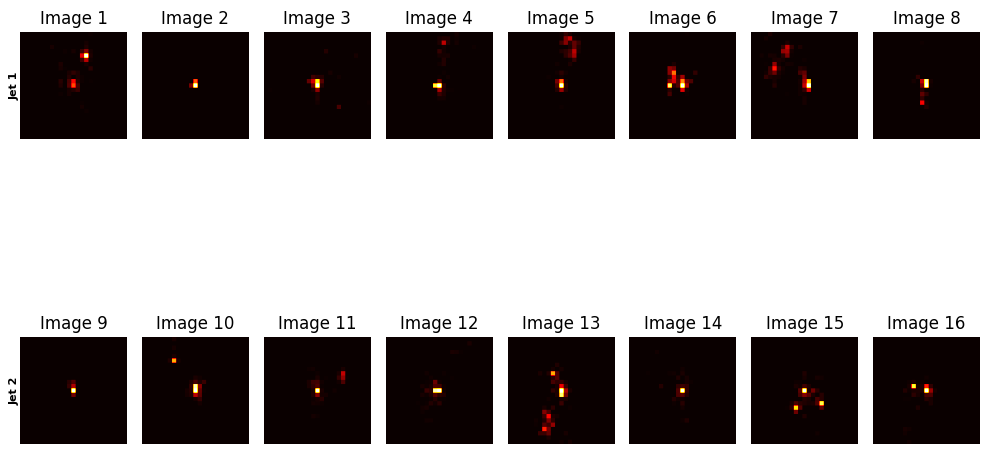

16

In [26]:
image_channel(2,4)

# Finding mean per features


In [27]:
import pyarrow.parquet as pq
import numpy as np
import random

# Load Parquet file
file = "/kaggle/input/topgun4d/top_gun_opendata_4.parquet"
df = pq.ParquetFile(file)

# Randomly select 10 row indices
num_samples = df.num_row_groups
random_indices = random.sample(range(num_samples), 10)

# Lists to store data
image_data = []
mass_values = []
pt_values = []

# Extract data from selected rows
for idx in random_indices:
    row = df.read_row_group(idx).to_pydict()
    
    # Extract image and reshape (8, 125, 125)
    image = np.array(row['X_jet'][0]).reshape(8, 125, 125)
    image_data.append(image)

    # Extract mass and pt values
    mass_values.append(row['m'][0])
    pt_values.append(row['pt'][0])

# Convert lists to numpy arrays
image_data = np.stack(image_data)  # Shape: (10, 8, 125, 125)
mass_values = np.array(mass_values)  # Shape: (10,)
pt_values = np.array(pt_values)  # Shape: (10,)

# Compute mean & std for images (per channel)
mean_img = image_data.mean(axis=(0, 2, 3))  # Mean per channel
std_img = image_data.std(axis=(0, 2, 3))    # Std per channel

# Compute mean & std for mass and pt
mean_m, std_m = mass_values.mean(), mass_values.std()
mean_pt, std_pt = pt_values.mean(), pt_values.std()

# Print results
print("Mean per channel (images):", mean_img)
print("Std per channel (images):", std_img)
print(f"Mass -> Mean: {mean_m}, Std: {std_m}")
print(f"Pt -> Mean: {mean_pt}, Std: {std_pt}")


Mean per channel (images): [ 0.02199236  0.0009458  -0.00075589  0.02354975  0.02129372  0.0018432
  0.0022592   0.002144  ]
Std per channel (images): [1.14561534 0.465918   0.76878258 0.88136482 0.27922638 0.04823072
 0.05343871 0.05149178]
Mass -> Mean: 350.7553741455078, Std: 90.43275760328976
Pt -> Mean: 734.4426849365234, Std: 196.9430606075485


# Another Way for data reading robust method

In [29]:
#DRFP(JetDataReadingandMakingItImageLike)
class DatasetReadingFromParquet(torch.utils.data.Dataset):
    def __init__(self, filename, transforms=None, return_regress=False, selected_channels=[4,5,6]):
        super().__init__()
        self.file = pq.ParquetFile(filename)
        self.return_regress = return_regress
        self.selected_channels = selected_channels  # Store selected channels
        
        # Define image normalization (Mean & Std from sampled data)
        image_mean = [0.0229907, -0.00107314, -0.00836261, 0.02673172, 
                      0.02135946, 0.0017856, 0.002144, 0.0023744]
        image_std = [1.35757413, 0.7131457, 4.25348895, 1.03409274, 
                     0.31701826, 0.0450068, 0.05136734, 0.05623488]
        
        # Store mean and std for selected channels only
        self.image_mean = torch.tensor([image_mean[i] for i in selected_channels], dtype=torch.float32).view(len(selected_channels), 1, 1)
        self.image_std = torch.tensor([image_std[i] for i in selected_channels], dtype=torch.float32).view(len(selected_channels), 1, 1)
        
        # Define mass and pt normalization
        self.mass_mean = 300
        self.mass_std = 120
        self.pt_mean = 750
        self.pt_std = 135

    def __getitem__(self, idx):
        row = self.file.read_row_group(idx).to_pydict()
        
        # Read and reshape image (C, H, W)
        X_jet = np.array(row['X_jet'][0]).reshape(8, 125, 125)
        
        # Select required channels
        X_jet = X_jet[self.selected_channels]  # Shape -> (len(selected_channels), 125, 125)

        # Convert to tensor and normalize
        X_jet = torch.tensor(X_jet, dtype=torch.float32, device=device)
        X_jet = (X_jet - self.image_mean.to(device)) / self.image_std.to(device)

        to_return = {"X_jet": X_jet}

        if self.return_regress:
            # Normalize mass and pt
            to_return["m"] = (row["m"][0] - self.mass_mean) / self.mass_std
            to_return["pt"] = (row["pt"][0] - self.pt_mean) / self.pt_std

        return to_return

    def __len__(self):
        return self.file.num_row_groups

In [30]:
f1 = "/kaggle/input/topgun4d/top_gun_opendata_4.parquet"

#f2 = "/kaggle/input/topgun/top_gun_opendata_2.parquet"

d_set = DatasetReadingFromParquet(f1, return_regress = True)

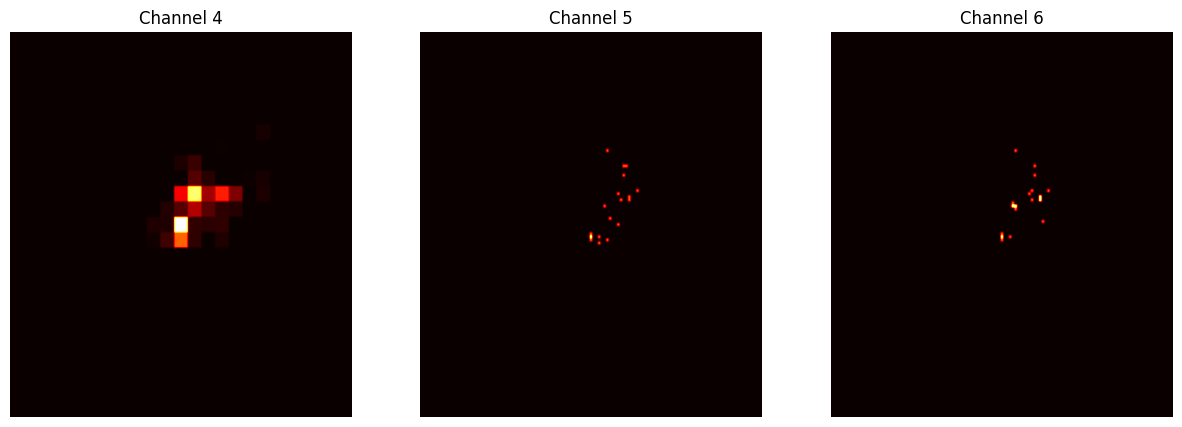

In [32]:
sample = d_set[0]  # Assuming dataset has at least one sample
X_jet = sample["X_jet"].cpu().numpy()  # Convert tensor to numpy for visualization


# Plot the selected channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
channel_names = ["Channel 4", "Channel 5", "Channel 6"]

for i in range(3):
    axes[i].imshow(X_jet[i], cmap="hot", aspect="auto")
    axes[i].set_title(channel_names[i])
    axes[i].axis("off")

plt.show()